# Sentiment model with CNNs

 - Use Convolutions to create a sentiment model.
 - Based on: http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/ 

In [4]:
#Imports 
from __future__ import print_function

import numpy as np

import tensorflow as tf
print(tf.__version__)

data_path='../data/aclImdb/'


1.3.0


## Read data and create sequences

In [2]:
# Generator of list of files in a folder and subfolders
import os
import fnmatch

def gen_find(filefilter, top):
    for path, dirlist, filelist in os.walk(top):
        for name in fnmatch.filter(filelist, filefilter):
            yield os.path.join(path, name)

def read_sentences(path):
    sentences = []
    sentences_list = gen_find("*.txt", path)
    for ff in sentences_list:
        with open(ff, 'r') as f:
            sentences.append(f.readline().strip())
    return sentences 

In [5]:
# Read train sentences and create train target

sentences_trn_pos = read_sentences(data_path+'train/pos/')
sentences_trn_neg = read_sentences(data_path+'train/neg/')

sentences_trn_ini = sentences_trn_pos + sentences_trn_neg
print('max_document_length trn: ', max([len(x.split(" ")) for x in sentences_trn_ini]))

y_trn_ini = np.array([[1.,0.]]*len(sentences_trn_pos) + [[0.,1.]]*len(sentences_trn_neg), dtype=np.float32)

print(y_trn_ini.shape)
print(y_trn_ini)


max_document_length trn:  2470
(25000, 2)
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]


In [6]:
# Shuffle train data
from sklearn.utils import shuffle
sentences_trn, y_trn = shuffle(sentences_trn_ini, y_trn_ini)

print(y_trn)

[[ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 ..., 
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]


In [7]:
# Read test sentences and create test target

sentences_tst_pos = read_sentences(data_path+'test/pos/')
sentences_tst_neg = read_sentences(data_path+'test/neg/')

sentences_tst = sentences_tst_pos + sentences_tst_neg
print('max_document_length tst: ', max([len(x.split(" ")) for x in sentences_tst]))

y_tst = np.array([[1.,0.]]*len(sentences_tst_pos) + [[0.,1.]]*len(sentences_tst_neg), dtype=np.float32)

print(y_tst.shape)


max_document_length tst:  2278
(25000, 2)


In [8]:
# Build vocabulary and transform sentences
from tensorflow.contrib import learn

sequence_length  =100

# Train vocab and apply to train
# https://github.com/tensorflow/tensorflow/blob/r1.4/tensorflow/contrib/learn/python/learn/preprocessing/text.py 
vocab_processor = learn.preprocessing.VocabularyProcessor(sequence_length, min_frequency=10)
X_trn = np.array(list(vocab_processor.fit_transform(sentences_trn)))

# Apply trained vocab to test 
X_tst = np.array(list(vocab_processor.transform(sentences_tst)))

# Size vocabulary
vocab_size = len(vocab_processor.vocabulary_)

# Check results
print('Vocab size: ', vocab_size)
print('X trn shape: ', X_trn.shape)
print('X tst shape: ', X_tst.shape)
print('First sentence: ', X_trn[0])
print('house id: ', vocab_processor.vocabulary_.get('house'))

Vocab size:  21740
X trn shape:  (25000, 100)
X tst shape:  (25000, 100)
First sentence:  [   45    59   154    85     1  7491  1581    50   525    44   963    16
  1236    35     1     0     0     2 13709  5272   470 10415    40    13
    11 13709 16500 16486  2743  2196   938   865 18372    35  8931  1085
     2  1055   205     1   126   556     4   996  7491  5524 15769    15
    11     6    12   240    27     1  2336    88   220   181     4    12
   702 17065     1    58   156     5    65     6   161     0     0     1
   367  4650   863     8  1244 12190   451     2   582 15543    16     1
  1221     4     0     2     0     0 10988     1   171   704  3953    45
     6     3    47  2773]
house id:  416


## The model
 - Declare placeholders
 - Embedding layers
 - Convolutional and max pooling layers
 - Merge convolutions oputput
 - Dense layer to predictions

In [9]:
# Model parameters
embedding_size = 128
num_filters = 32
filter_sizes = [3, 6, 12]

In [10]:
# Start an interactive session
gpu_options = tf.GPUOptions(allow_growth = True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True))


In [11]:
# Inputs
input_x = tf.placeholder(tf.int32, shape=[None, sequence_length], name="input_x")
print(input_x)

input_y = tf.placeholder(tf.int32, shape=[None, 2], name="input_y")
print(input_y)

dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")


Tensor("input_x:0", shape=(?, 100), dtype=int32)
Tensor("input_y:0", shape=(?, 2), dtype=int32)


In [12]:
# Embedding layer
with tf.name_scope("embedding"):
    W_embedding = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W_embedding")
    embedded_chars = tf.nn.embedding_lookup(W_embedding, input_x)
    print(embedded_chars)
    
    # Add an aditional dimension to match to the convolution requirements
    embedded_chars_expanded = tf.expand_dims(embedded_chars, -1)
    print(embedded_chars_expanded)
    

Tensor("embedding/embedding_lookup:0", shape=(?, 100, 128), dtype=float32)
Tensor("embedding/ExpandDims:0", shape=(?, 100, 128, 1), dtype=float32)


In [13]:
# Create a convolution + maxpool layer for each filter size

def conv_layer(x, size_x=2, size_y=2, input_channels=1, output_channels=32):
    W_conv = tf.Variable(tf.truncated_normal([size_x, size_y, input_channels, output_channels], stddev=0.1), name='W')
    
    b_conv = tf.Variable(tf.constant(0.1, shape=[output_channels]), name='b')
    
    conv_out = tf.nn.relu(tf.nn.conv2d(x, W_conv, strides=[1, 1, 1, 1], padding='VALID') + b_conv, name='conv')
    
    pooled = tf.nn.max_pool(conv_out, 
                            ksize=[1, sequence_length - filter_size + 1, 1, 1], 
                            strides=[1, 1, 1, 1], 
                            padding='VALID', 
                            name="pool")
    return pooled


pooled_outputs = []
for i, filter_size in enumerate(filter_sizes):
    with tf.name_scope("conv-maxpool-%s" % filter_size):
        pooled = conv_layer(embedded_chars_expanded, size_x=filter_size, size_y=embedding_size, input_channels=1, output_channels=num_filters)
        pooled_outputs.append(pooled)

print(pooled_outputs)

[<tf.Tensor 'conv-maxpool-3/pool:0' shape=(?, 1, 1, 32) dtype=float32>, <tf.Tensor 'conv-maxpool-6/pool:0' shape=(?, 1, 1, 32) dtype=float32>, <tf.Tensor 'conv-maxpool-12/pool:0' shape=(?, 1, 1, 32) dtype=float32>]


In [14]:
# Combine all the pooled features
h_pool = tf.concat(pooled_outputs, 3)
print(h_pool)

# Reshape to flat the tensor: f
num_filters_total = num_filters * len(filter_sizes)
h_pool_flat = tf.reshape(h_pool, [-1, num_filters_total])
print(h_pool_flat)

Tensor("concat:0", shape=(?, 1, 1, 96), dtype=float32)
Tensor("Reshape:0", shape=(?, 96), dtype=float32)


In [15]:
# Add dropout
with tf.name_scope("dropout"):
    h_drop = tf.nn.dropout(h_pool_flat, dropout_keep_prob)


In [16]:
# Final (unnormalized) scores and predictions
with tf.name_scope("output"):
    W = tf.get_variable("W", shape=[num_filters_total, 2], initializer=tf.contrib.layers.xavier_initializer())
    b = tf.Variable(tf.constant(0.1, shape=[2]), name="b")
    
    # scores = h_drop * W + b
    scores = tf.nn.xw_plus_b(h_drop, W, b, name="scores")
    print(scores)
    
    # predictions: position of the max value of scores
    predictions = tf.argmax(scores, 1, name="predictions")
    print(predictions)

Tensor("output/scores:0", shape=(?, 2), dtype=float32)
Tensor("output/predictions:0", shape=(?,), dtype=int64)


In [17]:
# Calculate the Mean of the cross-entropy loss in the batch
with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=scores, labels=input_y), name='loss')


In [18]:
# Accuracy: percent of correct predictions
with tf.name_scope("accuracy"):
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, tf.argmax(input_y, 1)), "float"), name="accuracy")

In [19]:
#Optimizer
with tf.name_scope("train") as scope:
    train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)


# Training procces
 - Create a generator to create the batches of inputs and targets. Train & test.
 - Iterate over the data to train the model
   - Each iteration over all the data is an epoch
   - For each epoch iterate overt the batches

In [20]:
def batch_iter(X, y, batch_size):
    """
    Generates a batch iterator for inputs (X) and targets (y) of batch_size size.
    """
    data_size = len(X)
    # Shuffle the data at each epoch
    shuffle_indices = np.random.permutation(np.arange(data_size))    
    shuffled_X = X[shuffle_indices]
    shuffled_y = y[shuffle_indices]
        
    num_batches = int((data_size-1)/batch_size) + 1
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        yield shuffled_X[start_index:end_index], shuffled_y[start_index:end_index]
        
# Test the generator function      
#b_iter= batch_iter(X_trn, y_trn, 2)
#print(b_iter.next()) #python2
#print(next(b_iter))  # python3

In [21]:
#Inicialization.
sess.run(tf.global_variables_initializer())

# Train proccess parameters
num_epochs = 15
batch_size = 128

loss_trn_epoch = []
loss_tst_epoch = []
acc_trn_epoch = []
acc_tst_epoch = []

print('e- LssTrn - AccTrn - LssTst - AccTst' )
for epoch in range(num_epochs):
    loss_trn = []
    acc_trn = []
    loss_tst = []
    acc_tst = []
    
    # Train step
    for x_batch, y_batch in batch_iter(X_trn, y_trn, batch_size):
        train_step.run(feed_dict={input_x: x_batch, input_y: y_batch, dropout_keep_prob: 0.5})
        loss_step, acc_step = sess.run([loss, accuracy], 
                                       feed_dict={input_x: x_batch, input_y: y_batch, dropout_keep_prob: 1})
        loss_trn += [loss_step]
        acc_trn += [acc_step]
    
    # Validation step
    for x_batch_test, y_batch_test in batch_iter(X_tst, y_tst, batch_size):
        loss_step, acc_step = sess.run([loss, accuracy], 
                                       feed_dict={input_x: x_batch_test, input_y: y_batch_test, dropout_keep_prob: 1})
        loss_tst += [loss_step]
        acc_tst += [acc_step]
    
    # Summary
    print(epoch, np.mean(loss_trn), np.mean(acc_trn), np.mean(loss_tst), np.mean(acc_tst))
    loss_trn_epoch += [np.mean(loss_trn)]
    loss_tst_epoch += [np.mean(loss_tst)]
    acc_trn_epoch += [np.mean(acc_trn)]
    acc_tst_epoch += [np.mean(acc_tst)]
    

e- LssTrn - AccTrn - LssTst - AccTst
0 0.723822 0.59945 0.631104 0.642467
1 0.586775 0.717594 0.618915 0.684096
2 0.589437 0.740665 0.610569 0.700574
3 0.567356 0.75177 0.582135 0.715521
4 0.529768 0.775829 0.555226 0.730094
5 0.484985 0.805612 0.52747 0.746963
6 0.429918 0.83231 0.498085 0.759965
7 0.364941 0.86419 0.478033 0.770225
8 0.298644 0.896604 0.468067 0.773701
9 0.228967 0.931122 0.473228 0.779775
10 0.164123 0.954871 0.497469 0.776563
11 0.114981 0.974203 0.516447 0.780437
12 0.0770785 0.98593 0.546564 0.779608
13 0.0504735 0.993136 0.582088 0.781242
14 0.0341943 0.996891 0.628246 0.775749


## Results

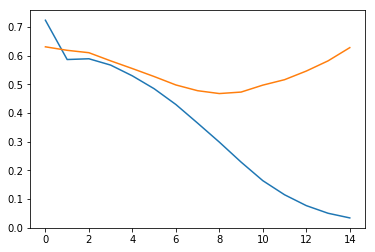

In [22]:
# Plot loss
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(loss_trn_epoch)
plt.plot(loss_tst_epoch)
plt.show()

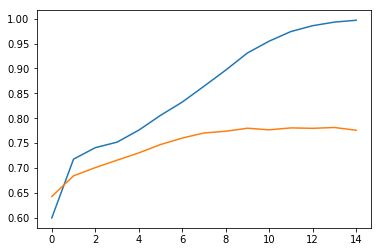

In [23]:
# Plot accuracy
plt.plot(acc_trn_epoch)
plt.plot(acc_tst_epoch)
plt.show()